# Extraction

In [ ]:
!pip install -U -q PyDrive
!pip install -U scikit-learn
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import scipy.stats as spst
from scipy.optimize import minimize
import scipy.special as spsp
import datetime

from sklearn.neighbors import KNeighborsClassifier

link="https://drive.google.com/open?id=1ekH_MmN_ofsmz6bR3xHrRnmDfXSDCWQK"
_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('myfile.csv')
hSSW_wdeltabike= pd.read_csv('myfile.csv')
print('hSSW_wdeltabike imported')

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22)
hSSW_wdeltabike imported


In [ ]:
hSSW_wdeltabike

,Unnamed: 0,station_id,bikes_available,docks_available,Holiday,Weekend,name,lat,long,dock_count,city,installation_date,delta_bike,datetime,Humidity,Pressure,Temperature,Weather_Description,Wind_Direction,Wind_Speed
0,0,2,2,25,False,False,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0
1,1,3,9,6,False,False,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0
2,2,4,0,11,False,False,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0
3,3,5,9,10,False,False,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0
4,4,6,4,11,False,False,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634687,634687,70,6,13,False,True,San Francisco Caltrain (Townsend at 4th),37.776617,-122.395260,19,San Francisco,8/23/2013,0.0,9/28/2014 14:00,100.0,1024,286.7370,sky is clear,159,1
634688,634688,71,5,14,False,True,Powell at Post (Union Square),37.788446,-122.408499,19,San Francisco,8/23/2013,-2.0,9/28/2014 14:00,100.0,1024,286.7370,sky is clear,159,1
634689,634689,72,14,9,False,True,Civic Center BART (7th at Market),37.781039,-122.411748,23,San Francisco,8/23/2013,0.0,9/28/2014 14:00,100.0,1024,286.7370,sky is clear,159,1
634690,634690,73,10,4,False,True,Grant Avenue at Columbus Avenue,37.798522,-122.407245,15,San Francisco,8/21/2013,-3.0,9/28/2014 14:00,100.0,1024,286.7370,sky is clear,159,1


In [ ]:
hSSW_wdeltabike['city'].unique()

array(['San Jose', 'Redwood City', 'Mountain View', 'Palo Alto',
       'San Francisco'], dtype=object)

In [ ]:
hSSW_wdeltabike['Weather_Description'].unique()

array(['broken clouds', 'mist', 'few clouds', 'sky is clear',
       'thunderstorm', 'scattered clouds', 'overcast clouds',
       'moderate rain', 'light rain', 'proximity thunderstorm', 'fog',
       'haze', 'light intensity drizzle', 'heavy intensity drizzle',
       'drizzle', 'thunderstorm with rain', 'proximity shower rain',
       'thunderstorm with light rain', 'heavy intensity rain',
       'very heavy rain', 'thunderstorm with heavy rain',
       'proximity thunderstorm with rain', 'light intensity shower rain'],
      dtype=object)

# Coherence Check and Cleaning

First, we plot the difference between available bikes and docks, and the count expected for  this station.

<BarContainer object of 14 artists>

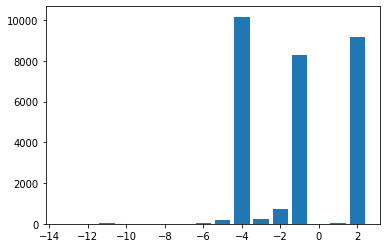

In [ ]:
hSSW_wdeltabike['check']=hSSW_wdeltabike['bikes_available']+hSSW_wdeltabike['docks_available']-hSSW_wdeltabike['dock_count']
unique,count=np.unique(hSSW_wdeltabike['check'],return_counts=True)
plt.bar(np.delete(unique,-3),np.delete(count,-3)) #delete count of value 0

For your information, we dropped the 0 differences, as they have no problem.
We see that we have approximately 30,000 samples with incorrect sums. If we can assume that negative sums are reflecting out of use docks, the positive sums are weird.

Let's breakdown these errors by stations

<BarContainer object of 69 artists>

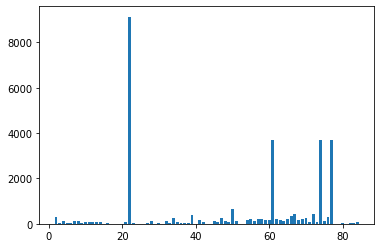

In [ ]:
unique_id,count_id=np.unique(hSSW_wdeltabike[hSSW_wdeltabike['check']!=0]['station_id'],return_counts=True)
plt.bar(unique_id,count_id)

In [ ]:
unique_id,count_id

(array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 21, 22, 23,
        24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42,
        45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 80, 82, 83,
        84], dtype=int64),
 array([ 298,   56,  124,   52,   38,  105,  110,   33,   78,   78,   83,
          98,   84,   50,   60, 9130,   22,    2,    4,   23,  122,    2,
          22,    5,  112,   45,  257,   70,   15,   30,   26,  382,  162,
         100,  133,   63,  261,  104,   79,  667,  110,  147,  227,  107,
         200,  212,  174,  161, 3675,  198,  170,  133,  207,  341,  434,
         172,  223,  246,   82,  434,   66, 3715,  118,  317, 3714,   19,
          56,   32,   66]))

In [ ]:
count_id[np.argsort(count_id)[-4:]],unique_id[np.argsort(count_id)[-4:]]

(array([3675, 3714, 3715, 9130]), array([61, 77, 74, 22], dtype=int64))

We see that 4 stations are generating almost the totality of the errors.

If we take a look at the station 22:

In [ ]:
np.unique(hSSW_wdeltabike[hSSW_wdeltabike['station_id']==22]['check'],return_counts=True)

(array([-1,  0,  1,  2], dtype=int64), array([   3,  250,   39, 9088]))

We observe that this station is generating almost all positive errors. Thus, we can certainly deduce an error in this dock count. In addition, the number of bikes and docks available is variable, contrary to the dock_count, which is fixed. If some docks are under repair, we will see them in the availability variable, but not in the dock_count.

In [ ]:
np.unique(hSSW_wdeltabike['dock_count'],return_counts=True)

(array([11, 15, 19, 23, 25, 27], dtype=int64),
 array([ 34598, 300137, 168663,  84397,   9380,  37517]))

To take into account this specificity, we implement a new column, called dock_total, which is the total of docks currently usable in the station (hence already used by a bike, or available).

In [ ]:
hSSW_wdeltabike['dock_total']=hSSW_wdeltabike['bikes_available']+hSSW_wdeltabike['docks_available']

# Categorical Label Implementation

We create our Status Categories:

In [ ]:
hSSW_wdeltabike['Category']=1

In [ ]:
hSSW_wdeltabike.loc[(hSSW_wdeltabike['bikes_available']/hSSW_wdeltabike['dock_total'])<0.1,'Category']=0
hSSW_wdeltabike.loc[(hSSW_wdeltabike['docks_available']/hSSW_wdeltabike['dock_total'])<0.1,'Category']=2

# Features Selection and Modification

In this part, we implement Features adaptations and modifications in order to work on an ML-adapted dataset.

### City

City is a categorical Variable, We Create OneHotEncoder to merge in the dataset.

In [ ]:
City=pd.get_dummies(hSSW_wdeltabike['city'])
City.head()

,Mountain View,Palo Alto,Redwood City,San Francisco,San Jose
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


### Weather

We see below that the Weather Description is a multiclass categorical variable. But we will have too many parameters.

Let's simplify these descriptions!

In [ ]:
hSSW_wdeltabike['Weather_Description'].unique()

array(['broken clouds', 'mist', 'few clouds', 'sky is clear',
       'thunderstorm', 'scattered clouds', 'overcast clouds',
       'moderate rain', 'light rain', 'proximity thunderstorm', 'fog',
       'haze', 'light intensity drizzle', 'heavy intensity drizzle',
       'drizzle', 'thunderstorm with rain', 'proximity shower rain',
       'thunderstorm with light rain', 'heavy intensity rain',
       'very heavy rain', 'thunderstorm with heavy rain',
       'proximity thunderstorm with rain', 'light intensity shower rain'],
      dtype=object)

Goal: Simplify the Weather Description to a more General weather:
- Sunny: Sky is clear
- Cloudy: Broken clouds, Few clouds, Scattered clouds, Overcast clouds
- Foggy: Mist, Fog, Haze, 
- Light Rain: light rain, light intensity drizzle, thunderstorm with light rain,light intensity shower rain
- Moderate Rain: moderate rain, drizzle, thunderstorm with rain
- Heavy Rain: heavy intensity rain, heavy intensity drizzle, thunderstorm with heavy rain, very heavy rain
- Proximity to Rain: thunderstorm, proximity thunderstorm, proximity shower rain, proximity thunderstorm with rain

In [ ]:
hSSW_wdeltabike['Weather_Simplified']=hSSW_wdeltabike['Weather_Description']

In [ ]:
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='sky is clear','Weather_Simplified']='Sunny'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='broken clouds','Weather_Simplified']='Cloudy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='few clouds','Weather_Simplified']='Cloudy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='scattered clouds','Weather_Simplified']='Cloudy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='overcast clouds','Weather_Simplified']='Cloudy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='mist','Weather_Simplified']='Foggy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='fog','Weather_Simplified']='Foggy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='haze','Weather_Simplified']='Foggy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='light rain','Weather_Simplified']='Light Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='light intensity drizzle','Weather_Simplified']='Light Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='thunderstorm with light rain','Weather_Simplified']='Light Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='light intensity shower rain','Weather_Simplified']='Light Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='moderate rain','Weather_Simplified']='Moderate Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='drizzle','Weather_Simplified']='Moderate Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='thunderstorm with rain','Weather_Simplified']='Moderate Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='heavy intensity rain','Weather_Simplified']='Heavy Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='heavy intensity drizzle','Weather_Simplified']='Heavy Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='thunderstorm with heavy rain','Weather_Simplified']='Heavy Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='very heavy rain','Weather_Simplified']='Heavy Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='thunderstorm','Weather_Simplified']='Proximity to Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='proximity thunderstorm','Weather_Simplified']='Proximity to Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='proximity shower rain','Weather_Simplified']='Proximity to Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='proximity thunderstorm with rain','Weather_Simplified']='Proximity to Rain'

We also add a binary variable, if the Weather is rainy or not, which would be more general than the description.

In [ ]:
hSSW_wdeltabike['Rain']=1
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Simplified']=='Sunny','Rain']=0
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Simplified']=='Cloudy','Rain']=0
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Simplified']=='Foggy','Rain']=0
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Simplified']=='Proximity to Rain','Rain']=0

Weather Description from 23 to 7 categories, and an additional dummy Rain column.

In [ ]:
Weather_Simplified=pd.get_dummies(hSSW_wdeltabike['Weather_Simplified'])
Weather_Simplified.head()

,Cloudy,Foggy,Heavy Rain,Light Rain,Moderate Rain,Proximity to Rain,Sunny
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


### Wind Direction

We also have the Wind Direction as an integer variable. We also decided to test categorical variables, using the Wind_Orientation. So we created dummies to see the effect on the algorithm.

In [ ]:
hSSW_wdeltabike['Wind_Orientation']='North'

In [ ]:
hSSW_wdeltabike.loc[(hSSW_wdeltabike['Wind_Direction'].astype(int)>45) & (hSSW_wdeltabike['Wind_Direction'].astype(int)<=135),'Wind_Orientation']='East'
hSSW_wdeltabike.loc[(hSSW_wdeltabike['Wind_Direction'].astype(int)>135) & (hSSW_wdeltabike['Wind_Direction'].astype(int)<=225),'Wind_Orientation']='South'
hSSW_wdeltabike.loc[(hSSW_wdeltabike['Wind_Direction'].astype(int)>225) & (hSSW_wdeltabike['Wind_Direction'].astype(int)<=315),'Wind_Orientation']='West'

In [ ]:
Wind_Orientation=pd.get_dummies(hSSW_wdeltabike['Wind_Orientation'])
Wind_Orientation.head()

,East,North,South,West
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


### Time

We also extracted from the Timestamp hours and months data.

In [ ]:
hSSW_wdeltabike['Hour']=hSSW_wdeltabike['datetime'].astype('datetime64').dt.hour
hSSW_wdeltabike['Month']=hSSW_wdeltabike['datetime'].astype('datetime64').dt.month

In [ ]:
hSSW_wdeltabike.head()

,Unnamed: 0,station_id,bikes_available,docks_available,Holiday,Weekend,name,lat,long,dock_count,city,installation_date,delta_bike,datetime,Humidity,Pressure,Temperature,Weather_Description,Wind_Direction,Wind_Speed,check,dock_total,Category,Weather_Simplified,Rain,Wind_Orientation,Hour,Month
0,0,2,2,25,False,False,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0,0,27,0,Cloudy,0,South,13,8
1,1,3,9,6,False,False,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0,0,15,1,Cloudy,0,South,13,8
2,2,4,0,11,False,False,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0,0,11,0,Cloudy,0,South,13,8
3,3,5,9,10,False,False,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0,0,19,1,Cloudy,0,South,13,8
4,4,6,4,11,False,False,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0,0,15,1,Cloudy,0,South,13,8


### Merge

To conclude, we merged all our dataset together to build the Machine Learning Dataset.

In [ ]:
ML_data=hSSW_wdeltabike[['Category','station_id','bikes_available','docks_available','Holiday','Weekend','Humidity','Pressure','Temperature',\
                         'Wind_Direction','Wind_Speed','Rain','Hour','Month']]

In [ ]:
ML_data=pd.merge(ML_data,City,left_index=True,right_index=True)
ML_data=pd.merge(ML_data,Weather_Simplified,left_index=True,right_index=True)
ML_data=pd.merge(ML_data,Wind_Orientation,left_index=True,right_index=True)

In [ ]:
ML_data=ML_data.astype({'Holiday': int, 'Weekend': int})

In [ ]:
ML_data

,Category,station_id,bikes_available,docks_available,Holiday,Weekend,Humidity,Pressure,Temperature,Wind_Direction,Wind_Speed,Rain,Hour,Month,Mountain View,Palo Alto,Redwood City,San Francisco,San Jose,Cloudy,Foggy,Heavy Rain,Light Rain,Moderate Rain,Proximity to Rain,Sunny,East,North,South,West
0,0,2,2,25,0,0,94.0,1021,287.2795,201,0,0,13,8,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
1,1,3,9,6,0,0,94.0,1021,287.2795,201,0,0,13,8,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
2,0,4,0,11,0,0,94.0,1021,287.2795,201,0,0,13,8,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
3,1,5,9,10,0,0,94.0,1021,287.2795,201,0,0,13,8,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
4,1,6,4,11,0,0,94.0,1021,287.2795,201,0,0,13,8,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634687,1,70,6,13,0,1,100.0,1024,286.7370,159,1,0,14,9,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
634688,1,71,5,14,0,1,100.0,1024,286.7370,159,1,0,14,9,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
634689,1,72,14,9,0,1,100.0,1024,286.7370,159,1,0,14,9,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
634690,1,73,10,4,0,1,100.0,1024,286.7370,159,1,0,14,9,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0


# Data Analysis

In this part, we focused on simple Analysis to better understand our dataset.

### Categories

Repartition of Station Status:

Text(0, 0.5, 'Number of Status Occurences')

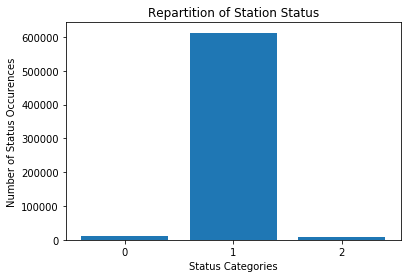

In [ ]:
categories=np.unique(ML_data['Category'],return_counts=True)
plt.bar(categories[0].astype('str'),categories[1])
plt.title('Repartition of Station Status')
plt.xlabel('Status Categories')
plt.ylabel('Number of Status Occurences')

We clearly see that the challenge of using Machine Learning algorithm will be to classify rare events regarding to normal ones.

### Analysis on rare events

We split our dataset to get only almost empty and full stations

In [ ]:
Problems_data=ML_data[ML_data['Category']!=1]

In [ ]:
problems_station=np.unique(Problems_data['station_id'],return_counts=True)

<BarContainer object of 69 artists>

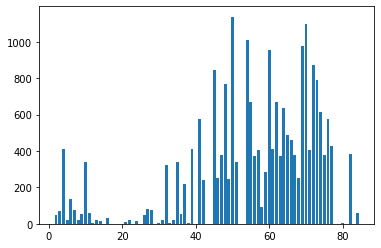

In [ ]:
plt.bar(problems_station[0],problems_station[1])

We observe that some stations are more likely to encounter problematic situations, but difficult to get identify a particular trend.

In [ ]:
ML_data['Rain'].mean()

0.10299956514340815

In [ ]:
Problems_data['Rain'].mean()

0.09064193222518138

Here again, difficult to identify a correlation between the rain and these rare events.

<BarContainer object of 24 artists>

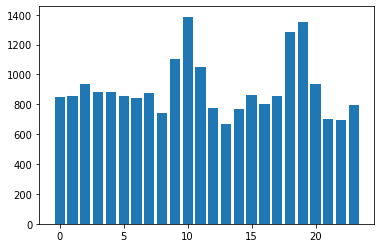

In [ ]:
problems_hour=np.unique(Problems_data['Hour'],return_counts=True)
plt.bar(problems_hour[0],problems_hour[1])

<BarContainer object of 12 artists>

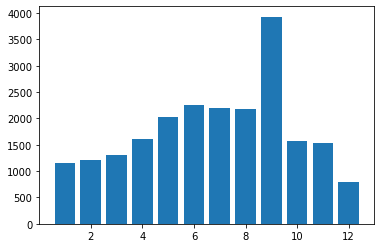

In [ ]:
problems_month=np.unique(Problems_data['Month'],return_counts=True)
plt.bar(problems_month[0],problems_month[1])

<BarContainer object of 12 artists>

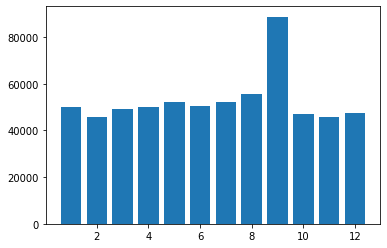

In [ ]:
ML_month=np.unique(ML_data['Month'],return_counts=True)
plt.bar(ML_month[0],ML_month[1])

We see that Hours and Months influence the problematic situations, as there are more problems in the system during rush hours and during the September month (mostly because we have one September Month more than other Months).

<BarContainer object of 4089 artists>

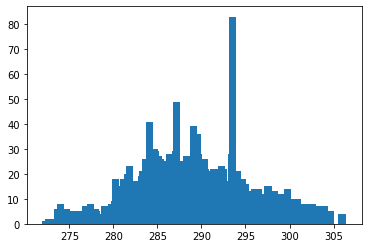

In [ ]:
problems_temperature=np.unique(Problems_data['Temperature'],return_counts=True)
plt.bar(problems_temperature[0],problems_temperature[1])

<BarContainer object of 4637 artists>

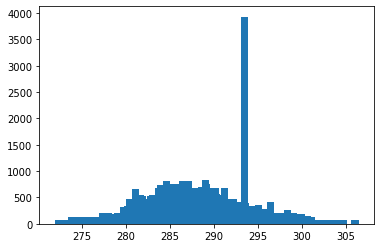

In [ ]:
ML_temperature=np.unique(ML_data['Temperature'],return_counts=True)
plt.bar(ML_temperature[0],ML_temperature[1])

Identically, difficult to find correlations between Empty/Full Stations and the Temperature.

After this analysis, we could jump to Machine Learning, by implementing our first KNearestNeighbor Classifier.